Use clustering, an unsupervised ML technique, to determine if a player's return ability is low, average, or high.

In [2]:
import pandas as pd
from catboost import CatBoostRegressor, Pool, cv
from sklearn.model_selection import train_test_split, KFold
import numpy as np
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
tennis_df = pd.read_excel("tennis.xlsx")

In [4]:
tennis_df.columns

Index(['X', 'tourney_id', 'tourney_name', 'surface', 'tourney_date',
       'match_date', 'match_num', 'round', 'best_of', 'gender', 'winner_id',
       'winner_seed', 'winner_rank', 'winner_name', 'winner_age',
       'winner_rating_score', 'winner_serve_ability', 'loser_id', 'loser_seed',
       'loser_rank', 'loser_name', 'loser_age', 'loser_rating_score',
       'loser_serve_ability', 'score', 'minutes', 'winner_aces',
       'winner_double_faults', 'winner_service_points',
       'winner_first_serves_in', 'winner_first_serves_won',
       'winner_second_serves_won', 'winner_break_points_saved',
       'winner_break_points_faced', 'winner_sets', 'winner_games',
       'loser_aces', 'loser_double_faults', 'loser_service_points',
       'loser_first_serves_in', 'loser_first_serves_won',
       'loser_second_serves_won', 'loser_break_points_saved',
       'loser_break_points_faced', 'loser_sets', 'loser_games'],
      dtype='object')

In [78]:
tennis_df.head(20)

,X,tourney_id,tourney_name,surface,tourney_date,match_date,match_num,round,best_of,gender,...,loser_service_points,loser_first_serves_in,loser_first_serves_won,loser_second_serves_won,loser_break_points_saved,loser_break_points_faced,loser_sets,loser_games,winner_returns_won,loser_returns_won
0,1,2019-520,Roland Garros,Clay,27/05/2019,27/05/2019,1123,R128,5,male,...,147.0,77.0,55.0,33.0,4.0,12.0,2.0,20.0,59.0,65.0
1,2,2019-520,Roland Garros,Clay,27/05/2019,27/05/2019,1153,R128,5,male,...,91.0,49.0,31.0,21.0,8.0,12.0,0.0,9.0,39.0,15.0
2,3,2019-520,Roland Garros,Clay,27/05/2019,27/05/2019,1118,R128,5,male,...,167.0,100.0,62.0,33.0,12.0,18.0,1.0,19.0,72.0,39.0
3,4,2019-520,Roland Garros,Clay,27/05/2019,27/05/2019,1116,R128,5,male,...,177.0,101.0,63.0,43.0,10.0,17.0,2.0,25.0,71.0,61.0
4,5,2019-520,Roland Garros,Clay,27/05/2019,27/05/2019,1151,R128,5,male,...,122.0,75.0,52.0,33.0,7.0,10.0,1.0,18.0,37.0,41.0
5,6,2019-520,Roland Garros,Clay,27/05/2019,27/05/2019,1122,R128,5,male,...,128.0,78.0,52.0,18.0,6.0,12.0,1.0,19.0,58.0,53.0
6,7,2019-520,Roland Garros,Clay,27/05/2019,27/05/2019,1155,R128,5,male,...,121.0,67.0,42.0,29.0,7.0,13.0,1.0,12.0,50.0,35.0
7,8,2019-520,Roland Garros,Clay,27/05/2019,27/05/2019,1108,R128,5,male,...,115.0,58.0,43.0,33.0,2.0,7.0,1.0,16.0,39.0,32.0
8,9,2019-520,Roland Garros,Clay,27/05/2019,27/05/2019,1146,R128,5,male,...,87.0,41.0,32.0,13.0,1.0,7.0,0.0,8.0,42.0,20.0
9,10,2019-520,Roland Garros,Clay,27/05/2019,27/05/2019,1159,R128,5,male,...,107.0,62.0,32.0,21.0,4.0,12.0,0.0,14.0,54.0,47.0


In [9]:
tennis_df[['score', 'winner_service_points', 'winner_first_serves_won', 'winner_second_serves_won', 'loser_service_points', 'loser_first_serves_won','loser_second_serves_won']].head()

,score,winner_service_points,winner_first_serves_won,winner_second_serves_won,loser_service_points,loser_first_serves_won,loser_second_serves_won
0,6-7(5) 6-3 3-6 6-2 6-2,170.0,72.0,33.0,147.0,55.0,33.0
1,6-1 6-4 6-4,72.0,34.0,23.0,91.0,31.0,21.0
2,7-5 6-7(4) 6-1 7-6(2),133.0,63.0,31.0,167.0,62.0,33.0
3,7-6(4) 6-3 2-6 6-7(5) 6-3,165.0,86.0,18.0,177.0,63.0,43.0
4,3-6 6-3 7-6(10) 6-3,132.0,68.0,23.0,122.0,52.0,33.0


In [13]:
tennis_df["winner_returns_won"] = tennis_df["loser_service_points"] - (tennis_df["loser_first_serves_won"] + tennis_df["loser_second_serves_won"])
tennis_df["loser_returns_won"] = tennis_df["winner_service_points"] - (tennis_df["winner_first_serves_won"] + tennis_df["winner_second_serves_won"])


In [14]:
tennis_subset = ['winner_service_points', 
 'winner_first_serves_won', 
 'winner_second_serves_won', 
 'loser_service_points', 
 'loser_first_serves_won',
 'loser_second_serves_won',
 'winner_returns_won',
 'loser_returns_won']

tennis_df[tennis_subset]

,winner_service_points,winner_first_serves_won,winner_second_serves_won,loser_service_points,loser_first_serves_won,loser_second_serves_won,winner_returns_won,loser_returns_won
0,170.0,72.0,33.0,147.0,55.0,33.0,59.0,65.0
1,72.0,34.0,23.0,91.0,31.0,21.0,39.0,15.0
2,133.0,63.0,31.0,167.0,62.0,33.0,72.0,39.0
3,165.0,86.0,18.0,177.0,63.0,43.0,71.0,61.0
4,132.0,68.0,23.0,122.0,52.0,33.0,37.0,41.0
...,...,...,...,...,...,...,...,...
4567,99.0,56.0,11.0,102.0,43.0,14.0,45.0,32.0
4568,98.0,41.0,19.0,110.0,47.0,16.0,47.0,38.0
4569,60.0,20.0,18.0,72.0,22.0,14.0,36.0,22.0
4570,109.0,48.0,27.0,106.0,49.0,14.0,43.0,34.0


In [ ]:
'winner_service_points'

- winner aces
- winner break points saved
- winner break points faced
- loser break points faced
- loser break points saved
- winner first serves in - winner first serves won = winner first serves lost (loser successful return points)
- loser first serves in - loser first serves won = loser first serves lost (winer successful return points)


### create a table that has return information for clustering:
1. Name
2. X
3. match_num
4. W or L
5. break points earned (opposite of break points faced)
6. break points won
7. First serve returns won

In [ ]:
# create a function that calculates break points earned
# create a function that calculates break points won
# create a function that calculates first serve returns won

In [8]:
# Create a new df

return_df = pd.DataFrame()
loop_columns = ["winner_name", "loser_name"]

# Calculate break points earned:

def break_points_earned():
    return_df["break_points_earned"] = loser_break_points_faced

In [19]:
def return_data_add(row):
    # Add winner names to the return_data dictionary
    return_data["name"].append(row["winner_name"])
    return_data["X"].append(row["X"])
    return_data["match_num"].append(row["match_num"])
    return_data["WorL"].append("W")
    return_data["break_points_earned"].append(row["loser_break_points_faced"])
    return_data["break_points_won"].append(row["loser_break_points_faced"]-row["loser_break_points_saved"])
    return_data["first_serve_returns_won"].append(row["loser_first_serves_in"]-row["loser_first_serves_won"])
    return_data["returns_won"].append(row["winner_returns_won"])

    # Add loser names to the return_data dictionary
    return_data["name"].append(row["loser_name"])
    return_data["X"].append(row["X"])
    return_data["match_num"].append(row["match_num"])
    return_data["WorL"].append("L")
    return_data["break_points_earned"].append(row["winner_break_points_faced"])
    return_data["break_points_won"].append(row["winner_break_points_faced"]-row["winner_break_points_saved"])
    return_data["first_serve_returns_won"].append(row["winner_first_serves_in"]-row["winner_first_serves_won"])
    return_data["returns_won"].append(row["loser_returns_won"])
    
    return return_data

In [79]:
def aces_dict_add(row):
    aces_dict_data["server"].append(row["winner_name"])
    aces_dict_data["returner"].append(row["loser_name"])
    aces_dict_data["X"].append(row["X"])
    aces_dict_data["match_num"].append(row["match_num"])
    aces_dict_data["WorL"].append("W")
    aces_dict_data["aces"].append(row["winner_aces"])
    aces_dict_data["male_or_female"].append(row["gender"])

    aces_dict_data["server"].append(row["loser_name"])
    aces_dict_data["returner"].append(row["winner_name"])
    aces_dict_data["X"].append(row["X"])
    aces_dict_data["match_num"].append(row["match_num"])
    aces_dict_data["WorL"].append("L")
    aces_dict_data["aces"].append(row["loser_aces"])
    aces_dict_data["male_or_female"].append(row["gender"])

    return aces_dict_data

In [80]:
return_data

{'name': ['Adrian Mannarino',
  'Stefano Travaglia',
  'Alex De Minaur',
  'Bradley Klahn',
  'Alexander Bublik',
  'Rudolf Molleker',
  'Alexander Zverev',
  'John Millman',
  'Alexei Popyrin',
  'Ugo Humbert',
  'Antoine Hoang',
  'Damir Dzumhur',
  'Benoit Paire',
  'Marius Copil',
  'Borna Coric',
  'Aljaz Bedene',
  'Casper Ruud',
  'Ernests Gulbis',
  'Corentin Moutet',
  'Alexey Vatutin',
  'Cristian Garin',
  'Reilly Opelka',
  'David Goffin',
  'Ricardas Berankis',
  'Diego Schwartzman',
  'Marton Fucsovics',
  'Dominic Thiem',
  'Tommy Paul',
  'Dusan Lajovic',
  'Thiago Monteiro',
  'Elliot Benchetrit',
  'Cameron Norrie',
  'Fabio Fognini',
  'Andreas Seppi',
  'Federico Delbonis',
  'Guillermo Garcia Lopez',
  'Fernando Verdasco',
  'Daniel Evans',
  'Filip Krajinovic',
  'Frances Tiafoe',
  'Gael Monfils',
  'Taro Daniel',
  'Gilles Simon',
  'Sergiy Stakhovsky',
  'Gregoire Barrere',
  'Matthew Ebden',
  'Grigor Dimitrov',
  'Janko Tipsarevic',
  'Guido Pella',
  'Guido 

In [81]:
return_data = {"name":[],
           "X":[],
           "match_num":[],
           "WorL":[],
           "break_points_earned":[],
           "break_points_won":[],
           "first_serve_returns_won":[],
           "returns_won":[]}

tennis_df.apply(return_data_add, axis=1)

0       {'name': ['Adrian Mannarino', 'Stefano Travagl...
1       {'name': ['Adrian Mannarino', 'Stefano Travagl...
2       {'name': ['Adrian Mannarino', 'Stefano Travagl...
3       {'name': ['Adrian Mannarino', 'Stefano Travagl...
4       {'name': ['Adrian Mannarino', 'Stefano Travagl...
                              ...                        
4567    {'name': ['Adrian Mannarino', 'Stefano Travagl...
4568    {'name': ['Adrian Mannarino', 'Stefano Travagl...
4569    {'name': ['Adrian Mannarino', 'Stefano Travagl...
4570    {'name': ['Adrian Mannarino', 'Stefano Travagl...
4571    {'name': ['Adrian Mannarino', 'Stefano Travagl...
Length: 4572, dtype: object

In [82]:
return_df = pd.DataFrame.from_dict(return_data)

In [83]:
return_df.head()

,name,X,match_num,WorL,break_points_earned,break_points_won,first_serve_returns_won,returns_won
0,Adrian Mannarino,1,1123,W,12.0,8.0,22.0,59.0
1,Stefano Travaglia,1,1123,L,12.0,4.0,33.0,65.0
2,Alex De Minaur,2,1153,W,12.0,4.0,18.0,39.0
3,Bradley Klahn,2,1153,L,2.0,0.0,6.0,15.0
4,Alexander Bublik,3,1118,W,18.0,6.0,38.0,72.0


In [85]:
aces_dict_data = {"server":[],
                  "returner":[],
                  "X":[],
                  "match_num":[],
                  "WorL":[],
                  "aces":[],
                  "male_or_female":[]
                 }

tennis_df.apply(aces_dict_add, axis=1)

0       {'server': ['Adrian Mannarino', 'Stefano Trava...
1       {'server': ['Adrian Mannarino', 'Stefano Trava...
2       {'server': ['Adrian Mannarino', 'Stefano Trava...
3       {'server': ['Adrian Mannarino', 'Stefano Trava...
4       {'server': ['Adrian Mannarino', 'Stefano Trava...
                              ...                        
4567    {'server': ['Adrian Mannarino', 'Stefano Trava...
4568    {'server': ['Adrian Mannarino', 'Stefano Trava...
4569    {'server': ['Adrian Mannarino', 'Stefano Trava...
4570    {'server': ['Adrian Mannarino', 'Stefano Trava...
4571    {'server': ['Adrian Mannarino', 'Stefano Trava...
Length: 4572, dtype: object

In [86]:
aces_df = pd.DataFrame.from_dict(aces_dict_data)

In [87]:
aces_df.head()

,server,returner,X,match_num,WorL,aces,male_or_female
0,Adrian Mannarino,Stefano Travaglia,1,1123,W,5.0,male
1,Stefano Travaglia,Adrian Mannarino,1,1123,L,13.0,male
2,Alex De Minaur,Bradley Klahn,2,1153,W,3.0,male
3,Bradley Klahn,Alex De Minaur,2,1153,L,5.0,male
4,Alexander Bublik,Rudolf Molleker,3,1118,W,30.0,male


In [89]:
len(aces_df[aces_df["male_or_female"]=="male"]["server"].unique())

320

In [99]:
len(aces_df[aces_df["male_or_female"]=="male"]["server"])

4572

In [100]:
len(aces_df[aces_df["male_or_female"]=="female"]["server"])

4572

<Axes: >

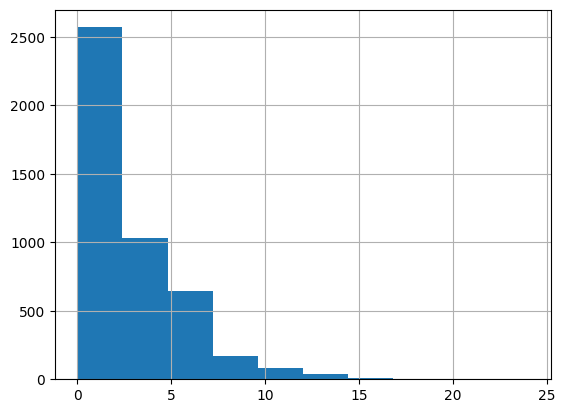

In [105]:
aces_df[aces_df["male_or_female"]=="female"]["aces"].hist()

<Axes: >

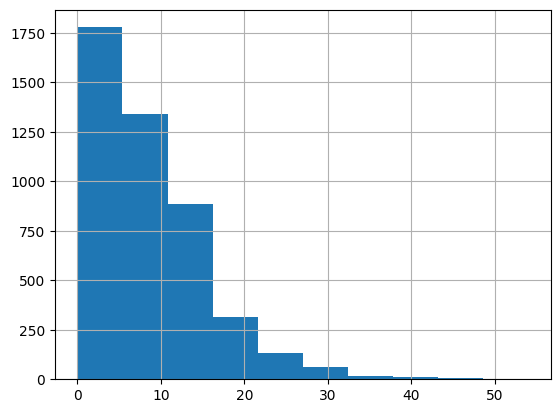

In [106]:
aces_df[aces_df["male_or_female"]=="male"]["aces"].hist()

In [70]:
aces_by_server = aces_df.groupby(["server", "returner"])

In [71]:
type(aces_by_server)

pandas.core.groupby.generic.DataFrameGroupBy

In [103]:
print(aces_df.shape)

(9144, 7)


In [75]:
aces_by_server.get_group(('Adrian Mannarino', 'Stefano Travaglia'))

,server,returner,X,match_num,WorL,aces
0,Adrian Mannarino,Stefano Travaglia,1,1123,W,5.0


In [91]:
serve_return_male = pd.pivot_table(aces_df[aces_df["male_or_female"]=="male"], values='aces', index=['server'],
                       columns=['returner'], aggfunc="mean")

In [98]:
serve_return_male.head(20)

returner,Adrian Mannarino,Alastair Gray,Albert Ramos,Alejandro Davidovich Fokina,Alejandro Tabilo,Aleksandar Kovacevic,Aleksandar Vukic,Alessandro Giannessi,Alex Bolt,Alex De Minaur,...,Yen Hsun Lu,Yibing Wu,Yoshihito Nishioka,Yosuke Watanuki,Yu Hsiou Hsu,Yuichi Sugita,Zachary Svajda,Zdenek Kolar,Zhizhen Zhang,Zizou Bergs
server,,,,,,,,,,,,,,,,,,,,,
Adrian Mannarino,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN
Alastair Gray,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Albert Ramos,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alejandro Davidovich Fokina,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,...,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alejandro Tabilo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Aleksandar Kovacevic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Aleksandar Vukic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alessandro Giannessi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alex Bolt,NaN,NaN,11.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We will use singular vector decomposition to fill the NaN values in our serve/return dataframe above. We will use this tutorial as inspitation: https://towardsdatascience.com/beginners-guide-to-creating-an-svd-recommender-system-1fd7326d1f65

## Train test split

In [162]:
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection.validation import cross_validate
from surprise.dataset import Dataset
from surprise.reader import Reader
from surprise import SVD
from surprise import KNNBasic
from surprise import KNNWithMeans

In [163]:
aces_df_female = aces_df[aces_df["male_or_female"]=="female"][["server","returner","aces"]].head()

In [164]:
# Make sure we get rid of aces values that are NaN because this will impact our model's ability to make predictions
aces_df_female = aces_df_female[aces_df_female["aces"].notna()]

In [165]:
# Because we are using the surprise package we will need to make sure our data is in the right format. 
# The default line format for Reader() is 'user item rating'. 
# What the code above is doing is creating our user-item interaction matrix

reader = Reader()
surprise_data = Dataset.load_from_df(aces_df_female, reader)

In [166]:
# Next, divide the data into 70% train, 30% test split

trainset, testset = train_test_split(surprise_data, test_size=.3, random_state=10)

In [167]:
# Next we create an instance of the model we want to try. Lets start with KNN with means
# The code below instantiates the model and fits it to the training data

model_KNNBasic= KNNBasic()
model_KNNBasic.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


NOTE_1: When we talk about training a kNN-with-Means recommender system, we are actually performing a process that involves organizing and preparing the data rather than optimizing a traditional cost function as in many other machine learning algorithms. The term "training" is still used because it involves preparing the model to make predictions effectively.

NOTE_2: When we fit the model to the training data we have created a similarity matrix! In the context of KNN, a similarity matrix typically represents the pairwise similarity between items or users. Each element of the matrix indicates the similarity between two items or users. This similarity can be calculated using various metrics such as cosine similarity, Pearson correlation, or Euclidean distance.

In [168]:
# predicting the test data
predictions = model_KNNBasic.test(testset)
rmse_ = round(accuracy.rmse(predictions), 3)
rmse_

RMSE: 1.0000


1.0

In [169]:
predictions[:5]

[Prediction(uid='Amanda Anisimova', iid='Harmony Tan', r_ui=0.0, est=1, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='Daria Saville', iid='Aleksandra Krunic', r_ui=2.0, est=1, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})]

## Approach 2

In [334]:
aces_df_female = aces_df[aces_df["male_or_female"]=="female"][["server","returner","aces"]]
aces_df_female.head()

,server,returner,aces
128,Aleksandra Krunic,Daria Saville,1.0
129,Daria Saville,Aleksandra Krunic,2.0
130,Aliona Bolsova,Vera Zvonareva,1.0
131,Vera Zvonareva,Aliona Bolsova,0.0
132,Amanda Anisimova,Harmony Tan,0.0


In [335]:
aces_df_female.shape


(4572, 3)

In [336]:
# min and max ratings will be used to normalize the ratings later
min_aces = min(aces_df_female["aces"])
max_aces = max(aces_df_female["aces"])

print(min_aces)
print(max_aces)

0.0
24.0


In [337]:
# Make sure we get rid of aces values that are NaN because this will impact our model's ability to make predictions
aces_df_female = aces_df_female[aces_df_female["aces"].notna()]

In [338]:
reader = Reader(rating_scale=(0.0, 24.0))
surprise_data = Dataset.load_from_df(aces_df_female[["server","returner","aces"]], reader)

In [339]:
# create train/test split
trainset, testset = train_test_split(surprise_data, test_size=.1, random_state=42)

In [340]:
def add_matches_to_testset(player1, player2):
    aces = aces_df_female[(aces_df_female["server"] == player2) & (aces_df_female["returner"] == player1)]["aces"].tolist()[0]
    output = (player2, player1, aces)
    return output

In [329]:
aces_df_female[(aces_df_female["server"] == "Daria Saville") & (aces_df_female["returner"] == "Aleksandra Krunic")]["aces"].tolist()[0]

2.0

In [341]:
# find the testset "matches" and add them to the testset
testset_additions = []
for item in testset:
    testset_additions.append(add_matches_to_testset(item[0], item[1]))

testset += testset_additions

In [342]:
len(testset)

910

In [343]:
svd = SVD(n_epochs=3)

cross_validate(
    svd, 
    surprise_data, 
    measures=['RMSE', 'MAE'], 
    cv=3, 
    verbose=True
)

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    2.5189  2.5157  2.5789  2.5379  0.0290  
MAE (testset)     1.9247  1.8871  1.9537  1.9218  0.0273  
Fit time          0.01    0.00    0.00    0.01    0.00    
Test time         0.01    0.01    0.00    0.01    0.00    


{'test_rmse': array([2.51894734, 2.51573358, 2.5788806 ]),
 'test_mae': array([1.924694  , 1.8871133 , 1.95371716]),
 'fit_time': (0.007895708084106445,
  0.004622936248779297,
  0.0041539669036865234),
 'test_time': (0.005869150161743164,
  0.005136966705322266,
  0.004163980484008789)}

The above shows that SVD model does a pretty good job at filling in the NaN values in the matrix

In [344]:
# predicting the test data
predictions = svd.test(testset)
rmse_ = round(accuracy.rmse(predictions), 3)
rmse_

RMSE: 2.4552


2.455

In [345]:
predictions[:10]

[Prediction(uid='Victoria Azarenka', iid='Danka Kovinic', r_ui=0.0, est=2.65441368550738, details={'was_impossible': False}),
 Prediction(uid='Misaki Doi', iid='Ajla Tomljanovic', r_ui=1.0, est=2.93255836278829, details={'was_impossible': False}),
 Prediction(uid='Olivia Gadecki', iid='Marta Kostyuk', r_ui=3.0, est=2.525646245499771, details={'was_impossible': False}),
 Prediction(uid='Simona Halep', iid='Camila Giorgi', r_ui=6.0, est=2.9012533980745414, details={'was_impossible': False}),
 Prediction(uid='Heather Watson', iid='Kaja Juvan', r_ui=2.0, est=2.6446596216856255, details={'was_impossible': False}),
 Prediction(uid='Bernarda Pera', iid='Angelique Kerber', r_ui=2.0, est=2.7908555549907854, details={'was_impossible': False}),
 Prediction(uid='Marta Kostyuk', iid='Naomi Osaka', r_ui=7.0, est=2.8572714050120713, details={'was_impossible': False}),
 Prediction(uid='Rebecca Peterson', iid='Iga Swiatek', r_ui=0.0, est=2.0798505282694064, details={'was_impossible': False}),
 Predicti

In [346]:
testset[:5]

[('Victoria Azarenka', 'Danka Kovinic', 0.0),
 ('Misaki Doi', 'Ajla Tomljanovic', 1.0),
 ('Olivia Gadecki', 'Marta Kostyuk', 3.0),
 ('Simona Halep', 'Camila Giorgi', 6.0),
 ('Heather Watson', 'Kaja Juvan', 2.0)]

In [203]:
# Dummy code to test my function below:

pred_set = [("Maria Sharapova", "Serena Williams", 0)]
prediction = svd.test(pred_set)
pred_ratings = np.array([pred.est for pred in prediction])

for pred in prediction:
    print(pred.est)

2.5881959984296325


In [201]:
prediction

[Prediction(uid='Maria Sharapova', iid='Serena Williams', r_ui=0, est=2.5881959984296325, details={'was_impossible': False})]

In [347]:
def generate_ace_prediction(model, server, returner):
    pred_set = [(server, returner, 0)]
    prediction = model.test(pred_set)

    for pred in prediction:
        return pred.est

In [348]:
def total_match_aces_prediction(player1, player2):
    return generate_ace_prediction(svd, player1, player2) + generate_ace_prediction(svd, player2, player1)

In [354]:
total_match_aces_prediction('Misaki Doi', 'Ajla Tomljanovic')

5.801436722945251

In [364]:
def total_match_aces_true(player1, player2):
    condition1 = ((aces_df_female["server"] == player1) & (aces_df_female["returner"] == player2))
    condition2 = ((aces_df_female["server"] == player2) & (aces_df_female["returner"] == player1))
    return aces_df_female[condition1 | condition2]["aces"].sum()

In [365]:
total_match_aces_true('Misaki Doi', 'Ajla Tomljanovic')

7.0

In [215]:
def total_match_aces_true()
testset

[('Maria Sharapova', 'Serena Williams', 1.0),
 ('Luksika Kumkhum', 'Madison Keys', 1.0),
 ('Veronika Kudermetova', 'Dalma Galfi', 3.0),
 ('Alison Riske Amritraj', 'Xiyu Wang', 1.0),
 ('Serena Williams', 'Anett Kontaveit', 11.0),
 ('Jessica Pegula', 'Misaki Doi', 4.0),
 ('Katie Boulter', 'Aryna Sabalenka', 3.0),
 ('Shuai Zhang', 'Karolina Pliskova', 0.0),
 ('Diana Shnaider', 'Beatriz Haddad Maia', 1.0),
 ('Martina Trevisan', 'Yulia Putintseva', 0.0),
 ('Petra Kvitova', 'Sofia Kenin', 2.0),
 ('Sorana Cirstea', 'Tatjana Maria', 0.0),
 ('Veronika Kudermetova', 'Maria Sakkari', 2.0),
 ('Nuria Parrizas Diaz', 'Claire Liu', 1.0),
 ('Daria Saville', 'Elina Svitolina', 0.0),
 ('Ekaterina Alexandrova', 'Ysaline Bonaventure', 5.0),
 ('Elisabetta Cocciaretto', 'Simona Waltert', 1.0),
 ('Karolina Muchova', 'Cori Gauff', 2.0),
 ('Misaki Doi', 'Shuai Zhang', 2.0),
 ('Jaqueline Cristian', 'Beatriz Haddad Maia', 8.0),
 ('Daria Kasatkina', 'Peyton Stearns', 0.0),
 ('Kristie Ahn', 'Caroline Wozniacki', 0